# Defacing pre-registration - Statistical analysis in R

In [106]:
# Helper function to diagnose linear mixed-effects model fit
visualize_lmer_fit <- function(model, figure_title= ""){
    # Install and load necessary packages
    library(lme4)
    library(ggplot2)
    library(grid)
    library(gridExtra)
    library(ggpubr)

    #Plot size
    options(repr.plot.width=15, repr.plot.height=10)

    # Extract residuals and fitted values
    residuals <- residuals(model)
    fitted_values <- fitted(model)

    # Extract random effects
    random_effects_list <- ranef(model)

    # Residuals vs Fitted Values plot
    residuals_plot <- ggplot(data = data.frame(Fitted = fitted_values, Residuals = residuals),
                            aes(x = Fitted, y = Residuals)) +
        geom_point() +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        theme(text = element_text(size = 46))+
        theme_minimal() +
        theme(plot.margin = unit(c(10,2,2,10), "mm")) +
        labs(title = "Residuals vs Fitted Values",
            x = "Fitted Values",
            y = "Residuals")
    

    # QQ plot of residuals
    qq_plot_residuals <- ggqqplot(residuals) +
        theme(text = element_text(size = 46))+
        theme_minimal() +
        theme(plot.margin = unit(c(10,10,2,2), "mm")) +
        labs(title = "QQ Plot of Residuals",
            x = "Theoretical Quantiles",
            y = "Sample Quantiles")    
    
    # Generate QQ plots for each random effect
    qq_plots_random_effects <- list()
    i <- 1
    for (re in names(random_effects_list)) {
        random_effects <- unlist(random_effects_list[[re]])
        qq_plot <- ggqqplot(random_effects) +
            theme(text = element_text(size = 46))+
            theme_minimal() +
            labs(title = paste("QQ Plot of Random Effects:", re),
                x = "Theoretical Quantiles",
                y = "Sample Quantiles")

        if (i%%2) {
            qq_plot <- qq_plot +
                theme(plot.margin = unit(c(2,2,10,10), "mm"))
        } else {
            qq_plot <- qq_plot +
                theme(plot.margin = unit(c(2,10,10,2), "mm"))
        }
                    
        qq_plots_random_effects[[re]] <- qq_plot
        i <- i + 1
    }
  
    # Combine all plots into a single figure
    combined_plots <- list(residuals_plot, qq_plot_residuals)
    combined_plots <- c(combined_plots, qq_plots_random_effects)
    combined_plot <- do.call(grid.arrange, c(combined_plots, ncol = 2))

    title_grob <- textGrob(figure_title, gp=gpar(fontsize=20))

    final_plot <- arrangeGrob(top= title_grob, combined_plot, ncol = 1)

    # Print the combined plot
    print(final_plot)

    return(final_plot)
}


## Load the simulated or collected manual ratings

In [107]:
df <- read.csv(file = '../../data/IXI_augmented_ratings_df.tsv', sep='\t')
# Drop columns we will not use in the analysis
df <- df[, !names(df) %in% c("dataset", "artifacts", "time_sec", "confidence", "comments", "randomized_id")]
# sort dataframe by subject ID
df <- df[order(df$subject),]
df

,rater_id,rating,defaced,subject
,<chr>,<dbl>,<int>,<int>
49,rater_03,3.45,0,12
100,rater_01,3.40,0,12
134,rater_04,3.50,0,12
192,rater_02,3.65,0,12
787,rater_04,3.90,1,12
1038,rater_02,3.50,1,12
1410,rater_03,2.75,1,12
1659,rater_01,3.40,1,12
180,rater_04,3.45,0,13


In [108]:
library(dplyr)
# When there are two ratings corresponding to one image, keep first rating only, as rm-ANOVA is not able to deal with duplicates
df_nodup <- df[!duplicated(df[c("subject", "defaced", "rater_id")]), ]
nrow(df_nodup)

[1] 1480

## Linear mixed-effects models

We will test if including the defacing factor as fixed effect improves the model fit using a likelihood-ratio test.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: as.numeric(rating) ~ (1 | subject) + (1 | rater_id)
   Data: df_nodup

     AIC      BIC   logLik deviance df.resid 
  1546.8   1568.0   -769.4   1538.8     1476 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3693 -0.5709  0.0442  0.6422  3.4396 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.14729  0.3838  
 rater_id (Intercept) 0.04958  0.2227  
 Residual             0.12169  0.3488  
Number of obs: 1480, groups:  subject, 185; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)   3.1242     0.1152   27.12

1 x 1 Matrix of class "dpoMatrix"
            (Intercept)
(Intercept)  0.01327258

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange      gtable[arrange]
2 2 (1-1,1-1) arrange text[GRID.text.5578]


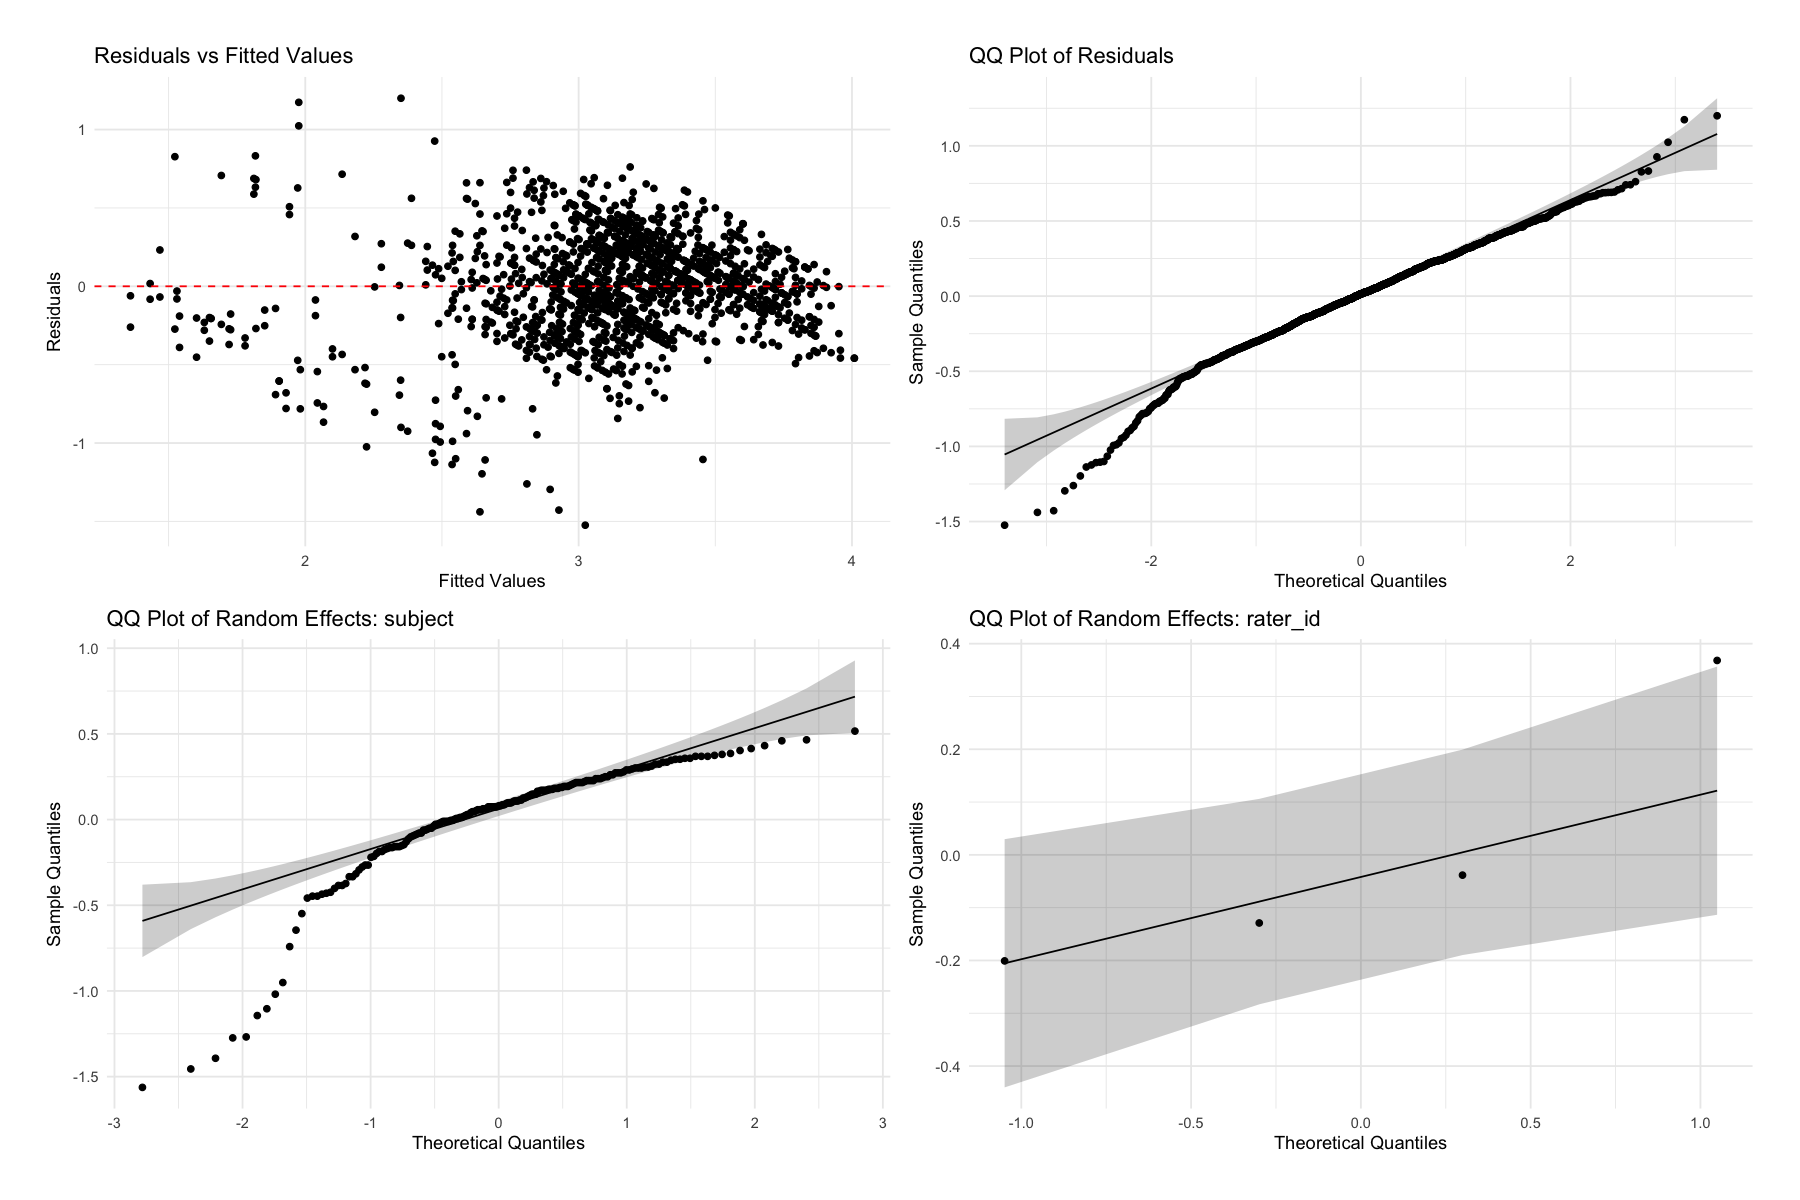

In [109]:
## Fit model without including defaced
library(lme4)
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=df_nodup, REML=FALSE)
summary(fm0)
vcov(fm0)
suppressWarnings(p0 <- visualize_lmer_fit(fm0, figure_title = "Baseline model with all raters"))


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id)
   Data: df_nodup

     AIC      BIC   logLik deviance df.resid 
  1542.5   1569.0   -766.3   1532.5     1475 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4451 -0.5861  0.0272  0.6272  3.3837 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.14736  0.3839  
 rater_id (Intercept) 0.04958  0.2227  
 Residual             0.12110  0.3480  
Number of obs: 1480, groups:  subject, 185; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)  3.10149    0.11556   26.84
defaced      0.04541    0.01809    2.51

Correlation of Fixed Effects:
        (Intr)
defaced -0.078

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange      gtable[arrange]
2 2 (1-1,1-1) arrange text[GRID.text.5737]


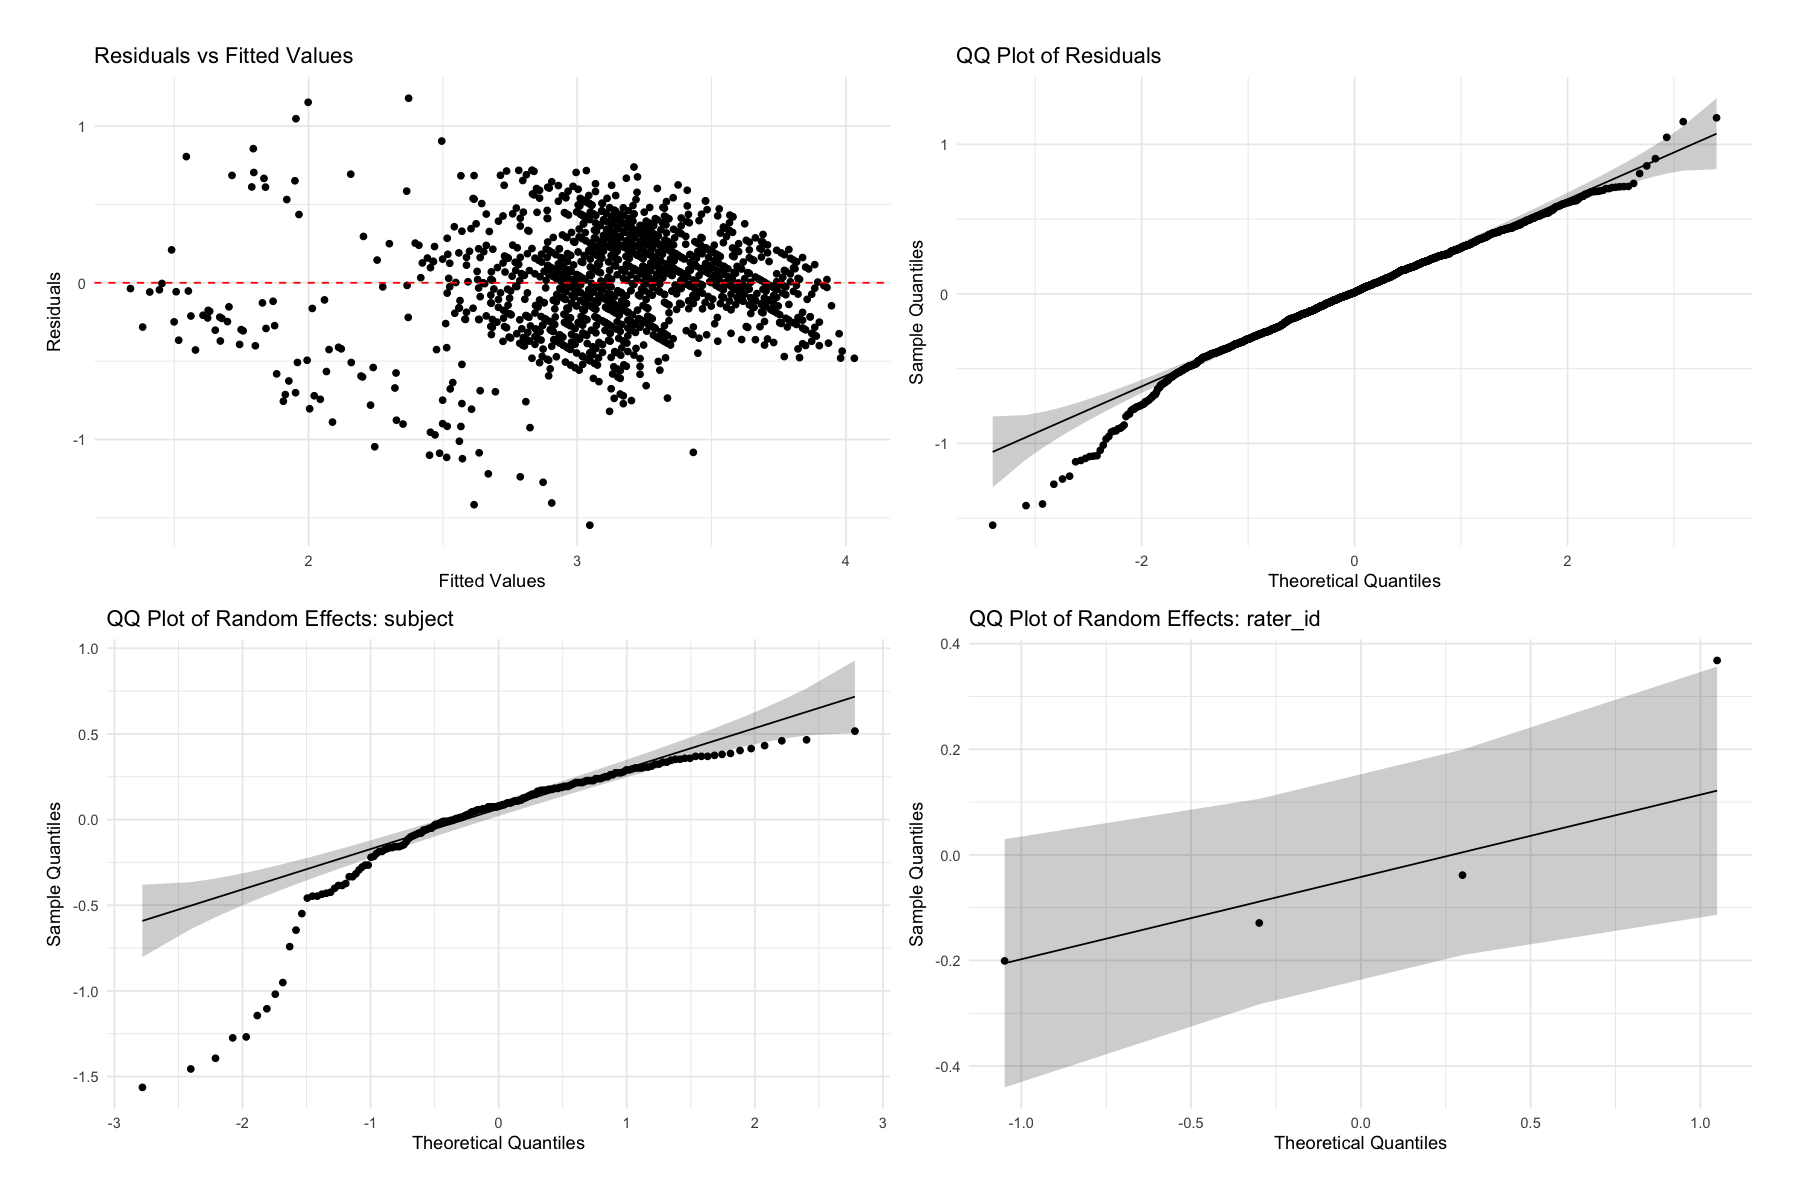

In [110]:
## Fit model including defaced
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id) , data=df_nodup, REML=FALSE)
summary(fm1)
suppressWarnings(p1 <- visualize_lmer_fit(fm1, figure_title = "Alternative model with all raters"))

In [111]:
library("bayestestR")
#Likelihood-ratio test
anova(fm0, fm1)

# Extract p-value
pval <- anova(fm0, fm1)$'Pr(>Chisq)'[2]


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,1546.788,1567.987,-769.3938,1538.788,NA,NA,NA
fm1,5,1542.504,1569.003,-766.2520,1532.504,6.283544,1,0.01218642


The p-value for the likelihood-ratio test is significant (3e-8) meaning that defacing influence on the manual ratings is significant.

## Exploratory analysis


### Linear mixed-effects without rater_04

In [112]:
#Remove rater_04
df_nodup_w04 <- df_nodup %>%
  filter(rater_id != "rater_04")
nrow(df_nodup_w04)

[1] 1110

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: as.numeric(rating) ~ (1 | subject) + (1 | rater_id)
   Data: df_nodup_w04

     AIC      BIC   logLik deviance df.resid 
  1326.1   1346.2   -659.1   1318.1     1106 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8200 -0.5850  0.0382  0.6406  3.1009 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.156950 0.39617 
 rater_id (Intercept) 0.004675 0.06837 
 Residual             0.135069 0.36752 
Number of obs: 1110, groups:  subject, 185; rater_id, 3

Fixed effects:
            Estimate Std. Error t value
(Intercept)  3.00063    0.05028   59.67

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange      gtable[arrange]
2 2 (1-1,1-1) arrange text[GRID.text.5896]


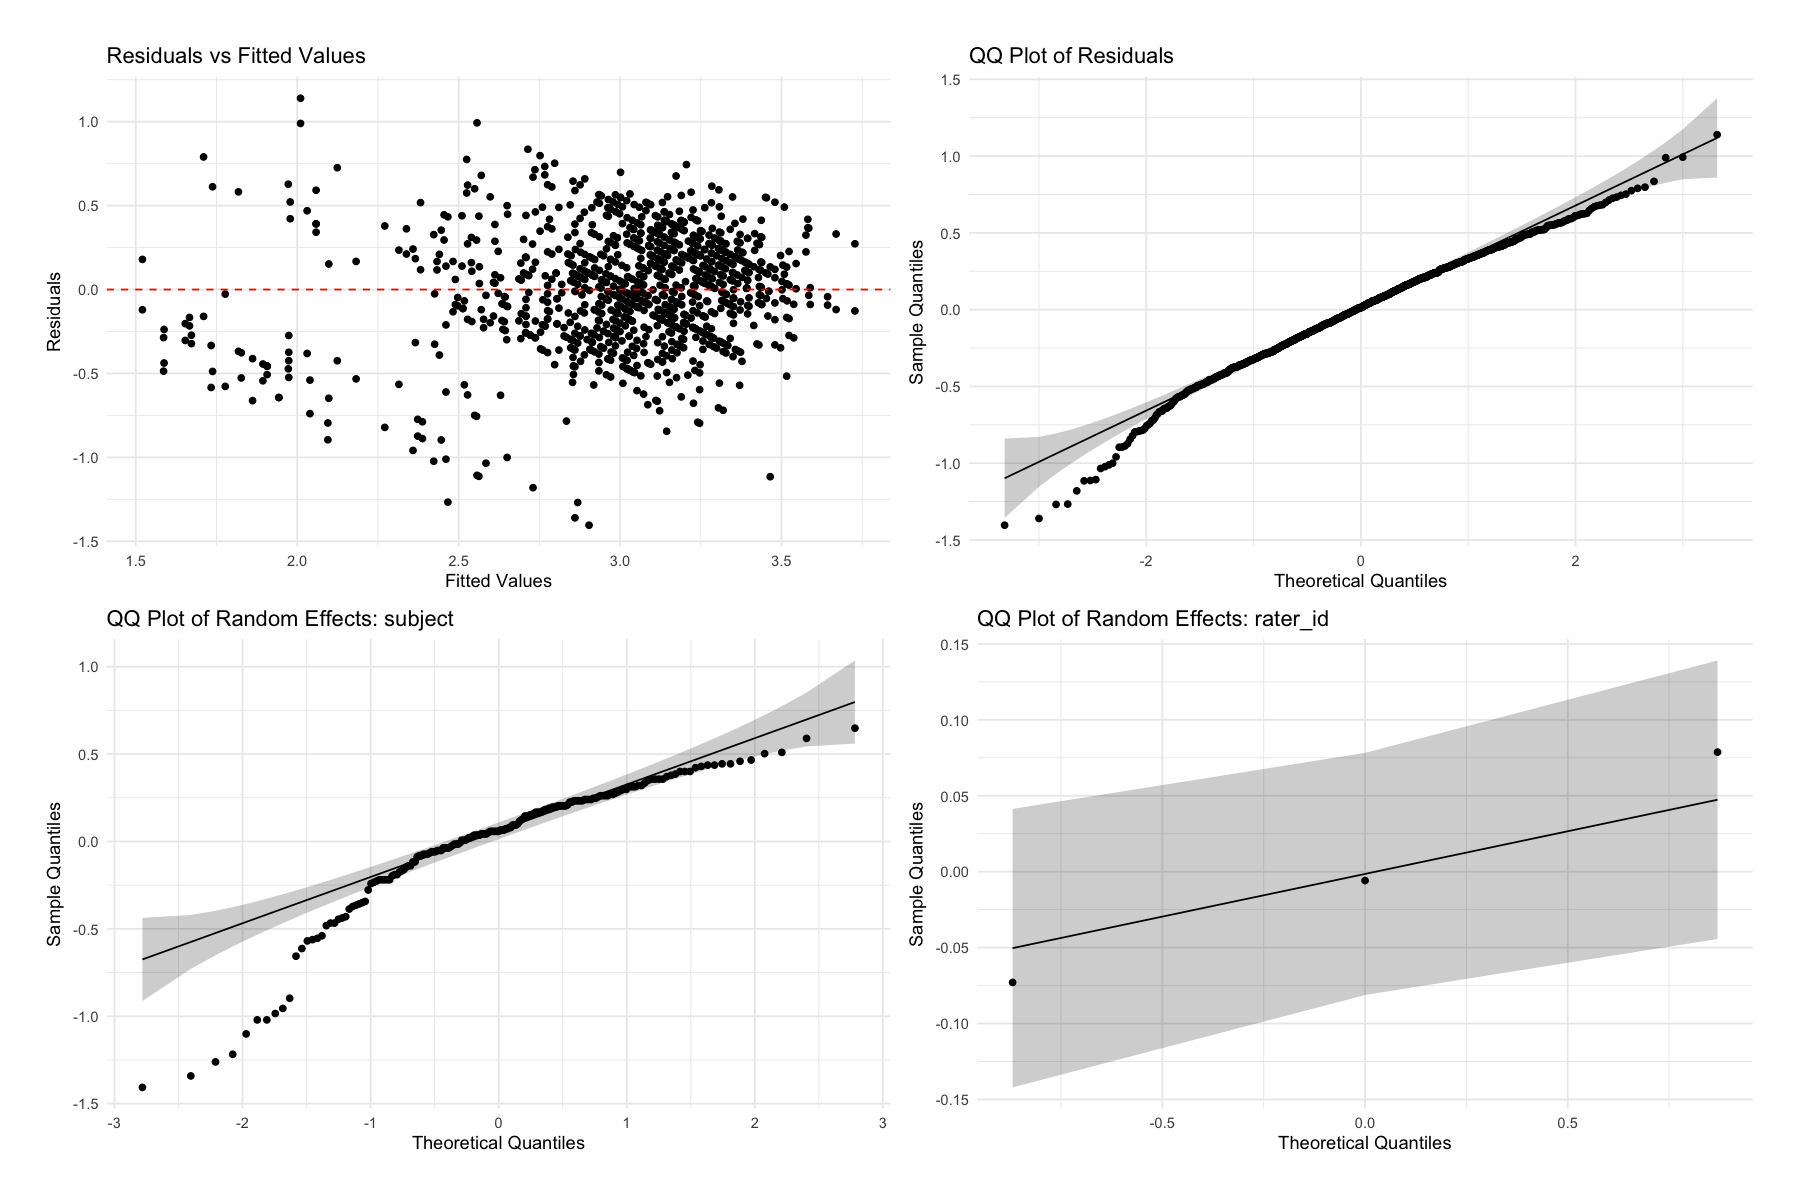

In [113]:
## Fit model without including defaced
library(lme4)
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=df_nodup_w04, REML=FALSE)
summary(fm0)
suppressWarnings(p0_w04 <- visualize_lmer_fit(fm0, figure_title = "Baseline model without rater_04"))


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id)
   Data: df_nodup_w04

     AIC      BIC   logLik deviance df.resid 
  1321.0   1346.1   -655.5   1311.0     1105 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9146 -0.5827  0.0495  0.6543  3.0357 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.157123 0.3964  
 rater_id (Intercept) 0.004678 0.0684  
 Residual             0.134032 0.3661  
Number of obs: 1110, groups:  subject, 185; rater_id, 3

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.97126    0.05148  57.718
defaced      0.05874    0.02198   2.673

Correlation of Fixed Effects:
        (Intr)
defaced -0.213

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange      gtable[arrange]
2 2 (1-1,1-1) arrange text[GRID.text.6055]


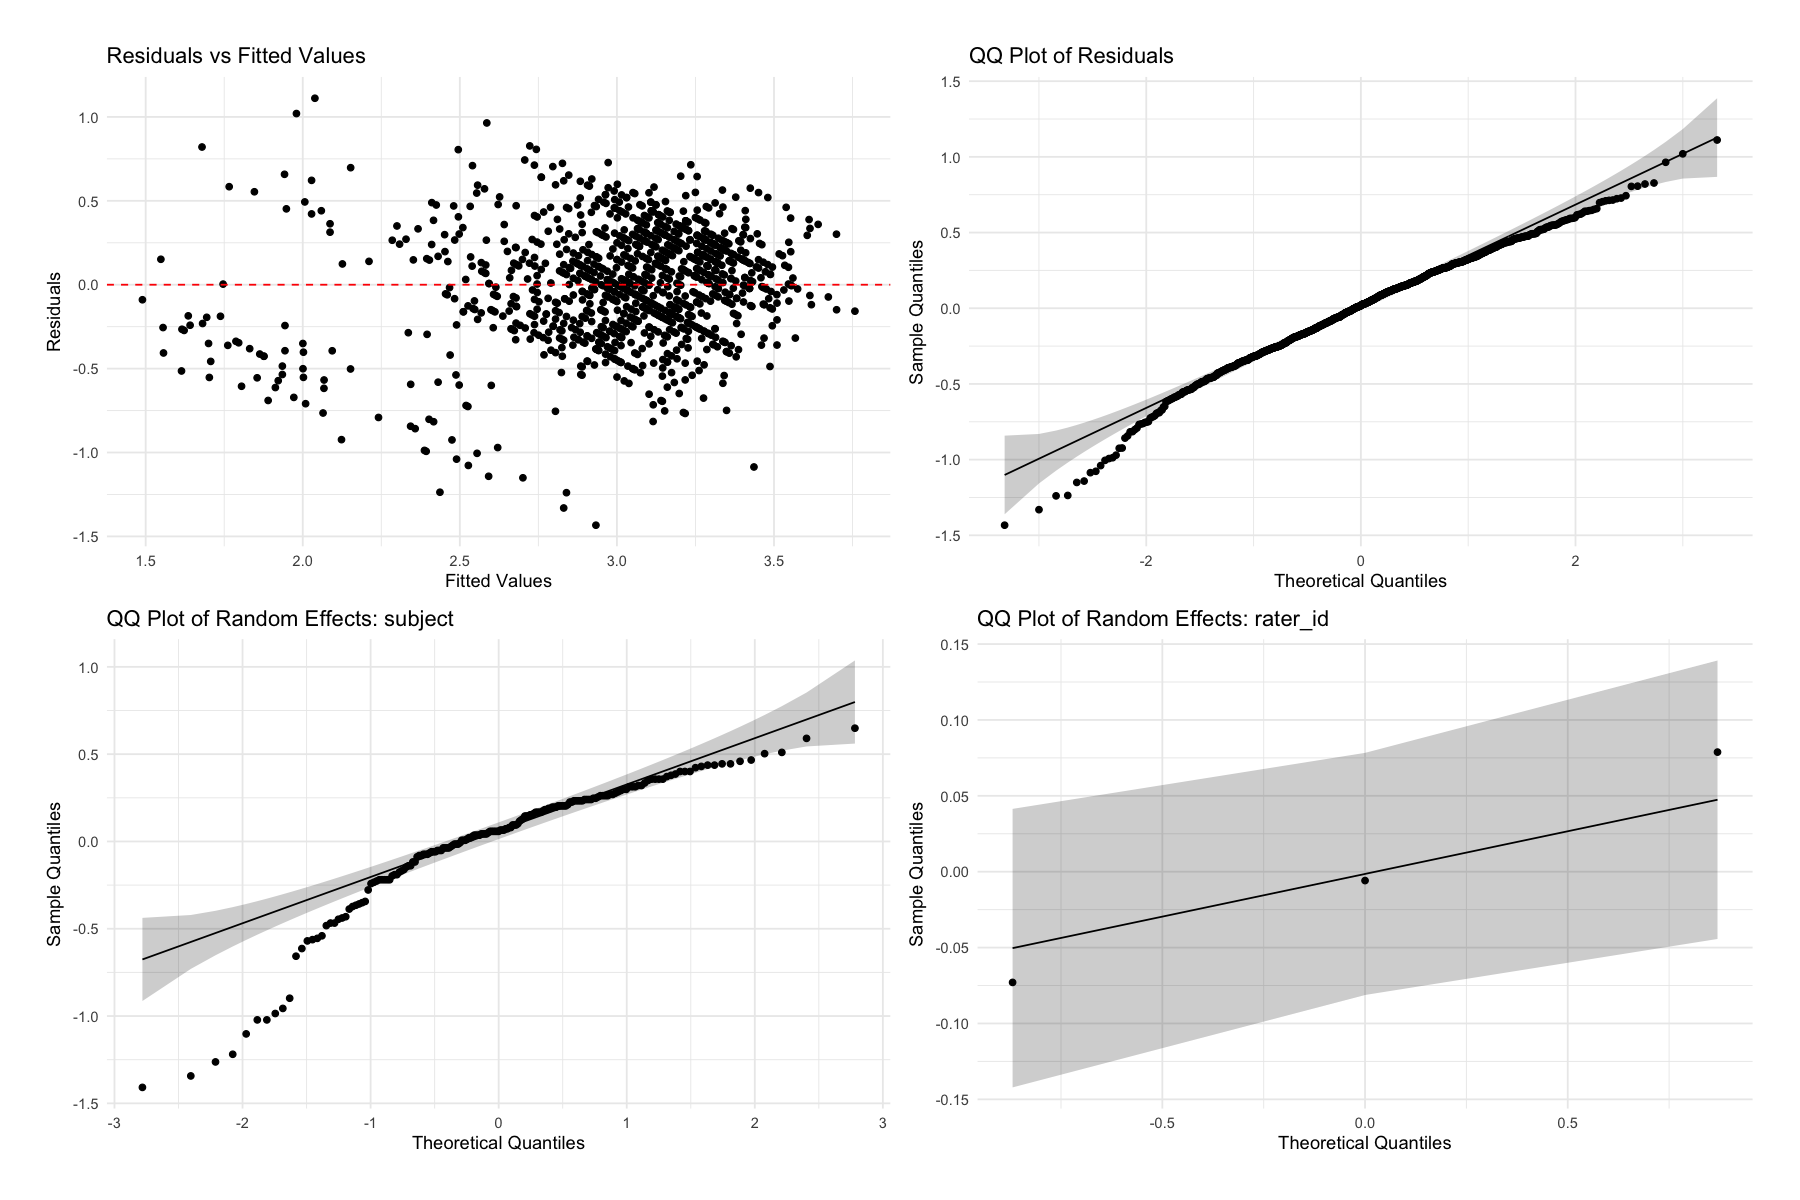

In [114]:
## Fit model including defaced
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id), data=df_nodup_w04, REML=FALSE)
summary(fm1)
suppressWarnings(p1_w04 <- visualize_lmer_fit(fm1, figure_title = "Alternative model without rater_04"))

In [115]:
#Likelihood-ratio test
anova(fm0, fm1)

# Extract p-value
pval_w04 <- anova(fm0, fm1)$'Pr(>Chisq)'[2]

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,1326.116,1346.164,-659.0578,1318.116,NA,NA,NA
fm1,5,1321.000,1346.060,-655.4998,1311.000,7.115882,1,0.007640401


### Linear mixed-effects with only poor quality and excluded scans

In [116]:
library(dplyr)
df_poor <- df_nodup %>%
  filter(rating <= 2.45)
nrow(df_poor)

[1] 152

In [117]:
library(dplyr)

# Filter data for defaced=0 and defaced=1
df_nondefaced <- df_poor %>% filter(defaced == 0)
df_defaced <- df_poor %>% filter(defaced == 1)

# Count unique combinations of rater_id and subject for each condition
unique_images_nondefaced <- df_nondefaced %>% distinct(rater_id, subject)
unique_images_defaced <- df_defaced %>% distinct(rater_id, subject)

# Identify common image pairs between the two conditions
common_images <- inner_join(unique_images_nondefaced, unique_images_defaced, by = c("rater_id", "subject"))

# Output the results
num_image_pairs <- nrow(common_images)
num_images_nondefaced <- nrow(unique_images_nondefaced)
num_images_defaced <- nrow(unique_images_defaced)

list(
  num_image_pairs = num_image_pairs,
  num_images_nondefaced = num_images_nondefaced,
  num_images_defaced = num_images_defaced
)

$num_image_pairs
[1] 41

$num_images_nondefaced
[1] 80

$num_images_defaced
[1] 72

Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(rating) ~ (1 | subject) + (1 | rater_id)
   Data: df_poor

REML criterion at convergence: 161.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.96636 -0.69405  0.03631  0.63993  2.39493 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.1118   0.3343  
 rater_id (Intercept) 0.0124   0.1113  
 Residual             0.1015   0.3186  
Number of obs: 152, groups:  subject, 59; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.05091    0.07863   26.08

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange      gtable[arrange]
2 2 (1-1,1-1) arrange text[GRID.text.6214]


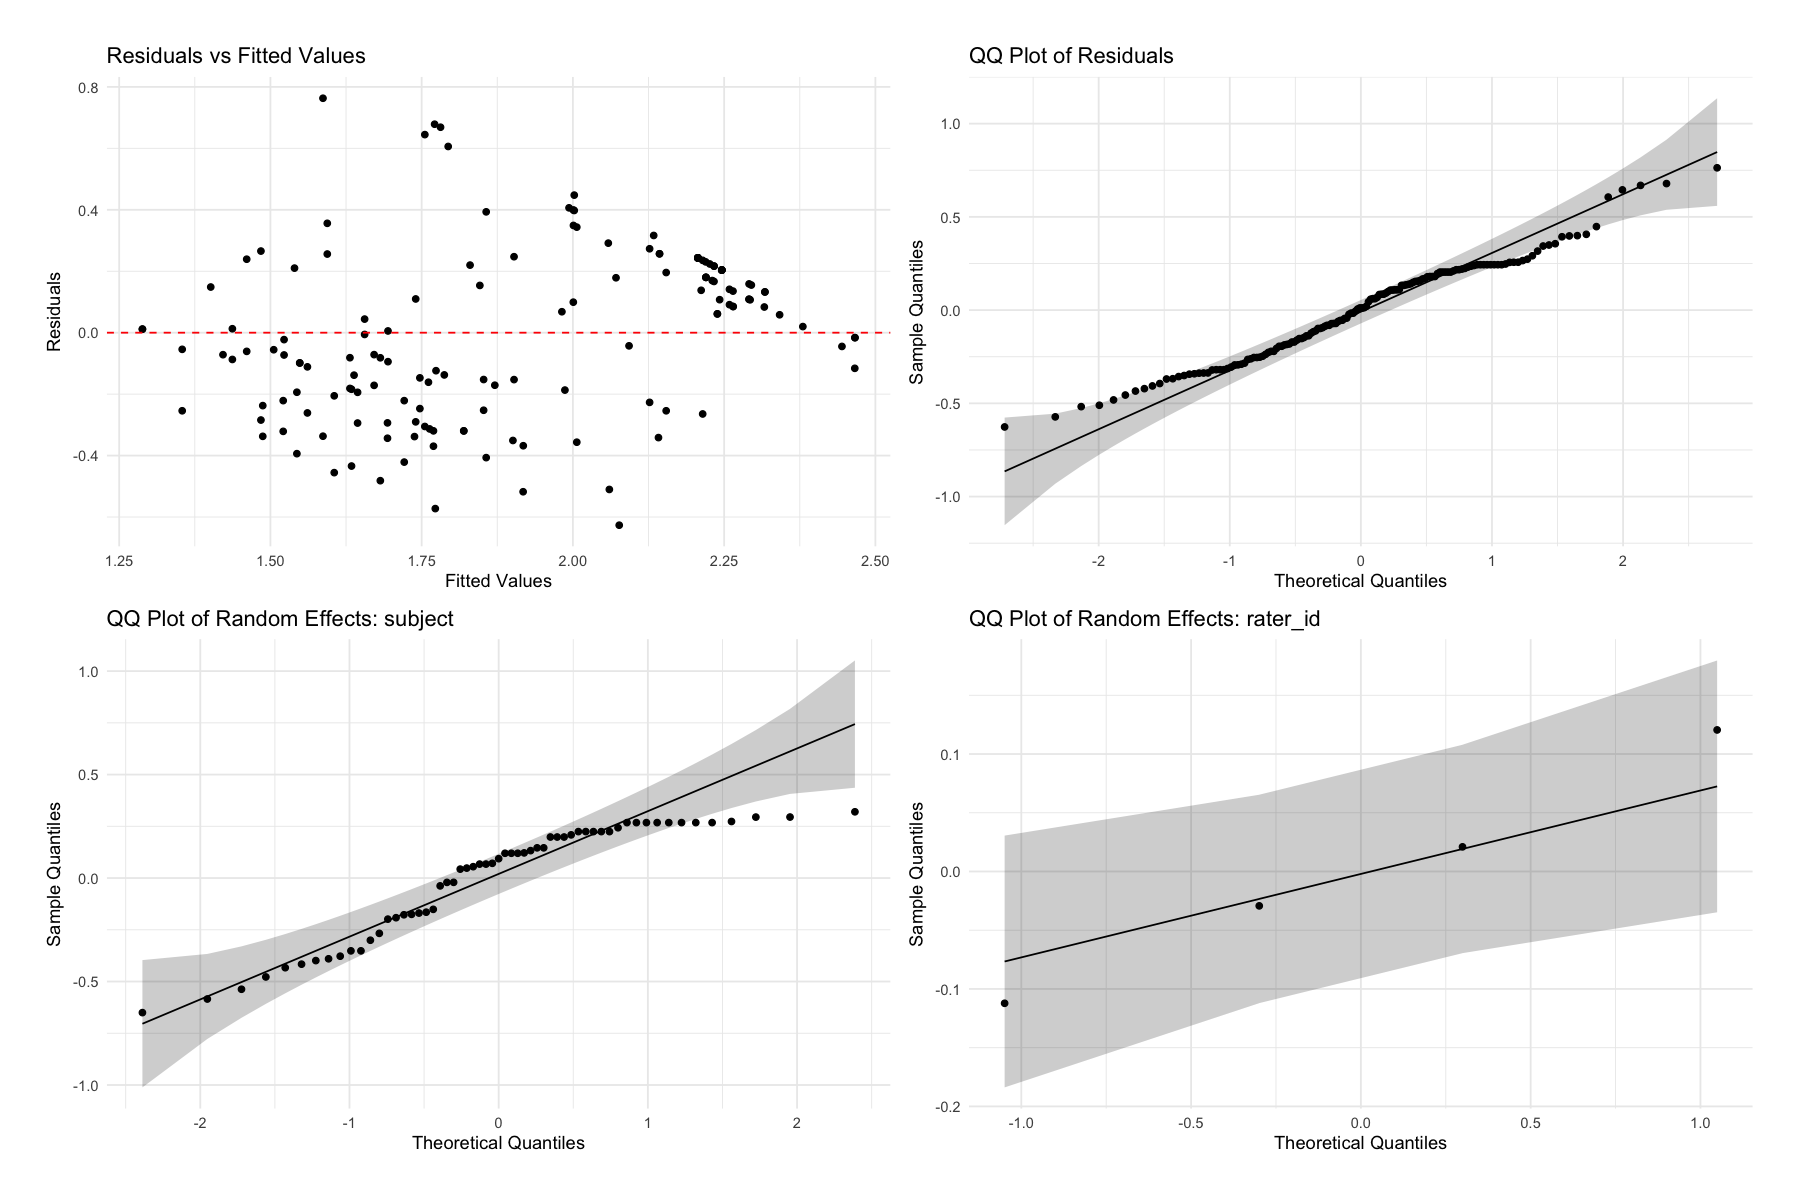

In [118]:
## Fit model without defaced as random effect
library(lme4)
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=df_poor)
summary(fm0)
suppressWarnings(p0_poor <- visualize_lmer_fit(fm0, figure_title = "Baseline model with only poor quality and excluded scans"))

Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id)
   Data: df_poor

REML criterion at convergence: 161.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9080 -0.6581  0.0178  0.5869  2.2435 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.11410  0.3378  
 rater_id (Intercept) 0.01302  0.1141  
 Residual             0.09761  0.3124  
Number of obs: 152, groups:  subject, 59; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.99907    0.08367  23.894
defaced      0.11809    0.05568   2.121

Correlation of Fixed Effects:
        (Intr)
defaced -0.306

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange      gtable[arrange]
2 2 (1-1,1-1) arrange text[GRID.text.6373]


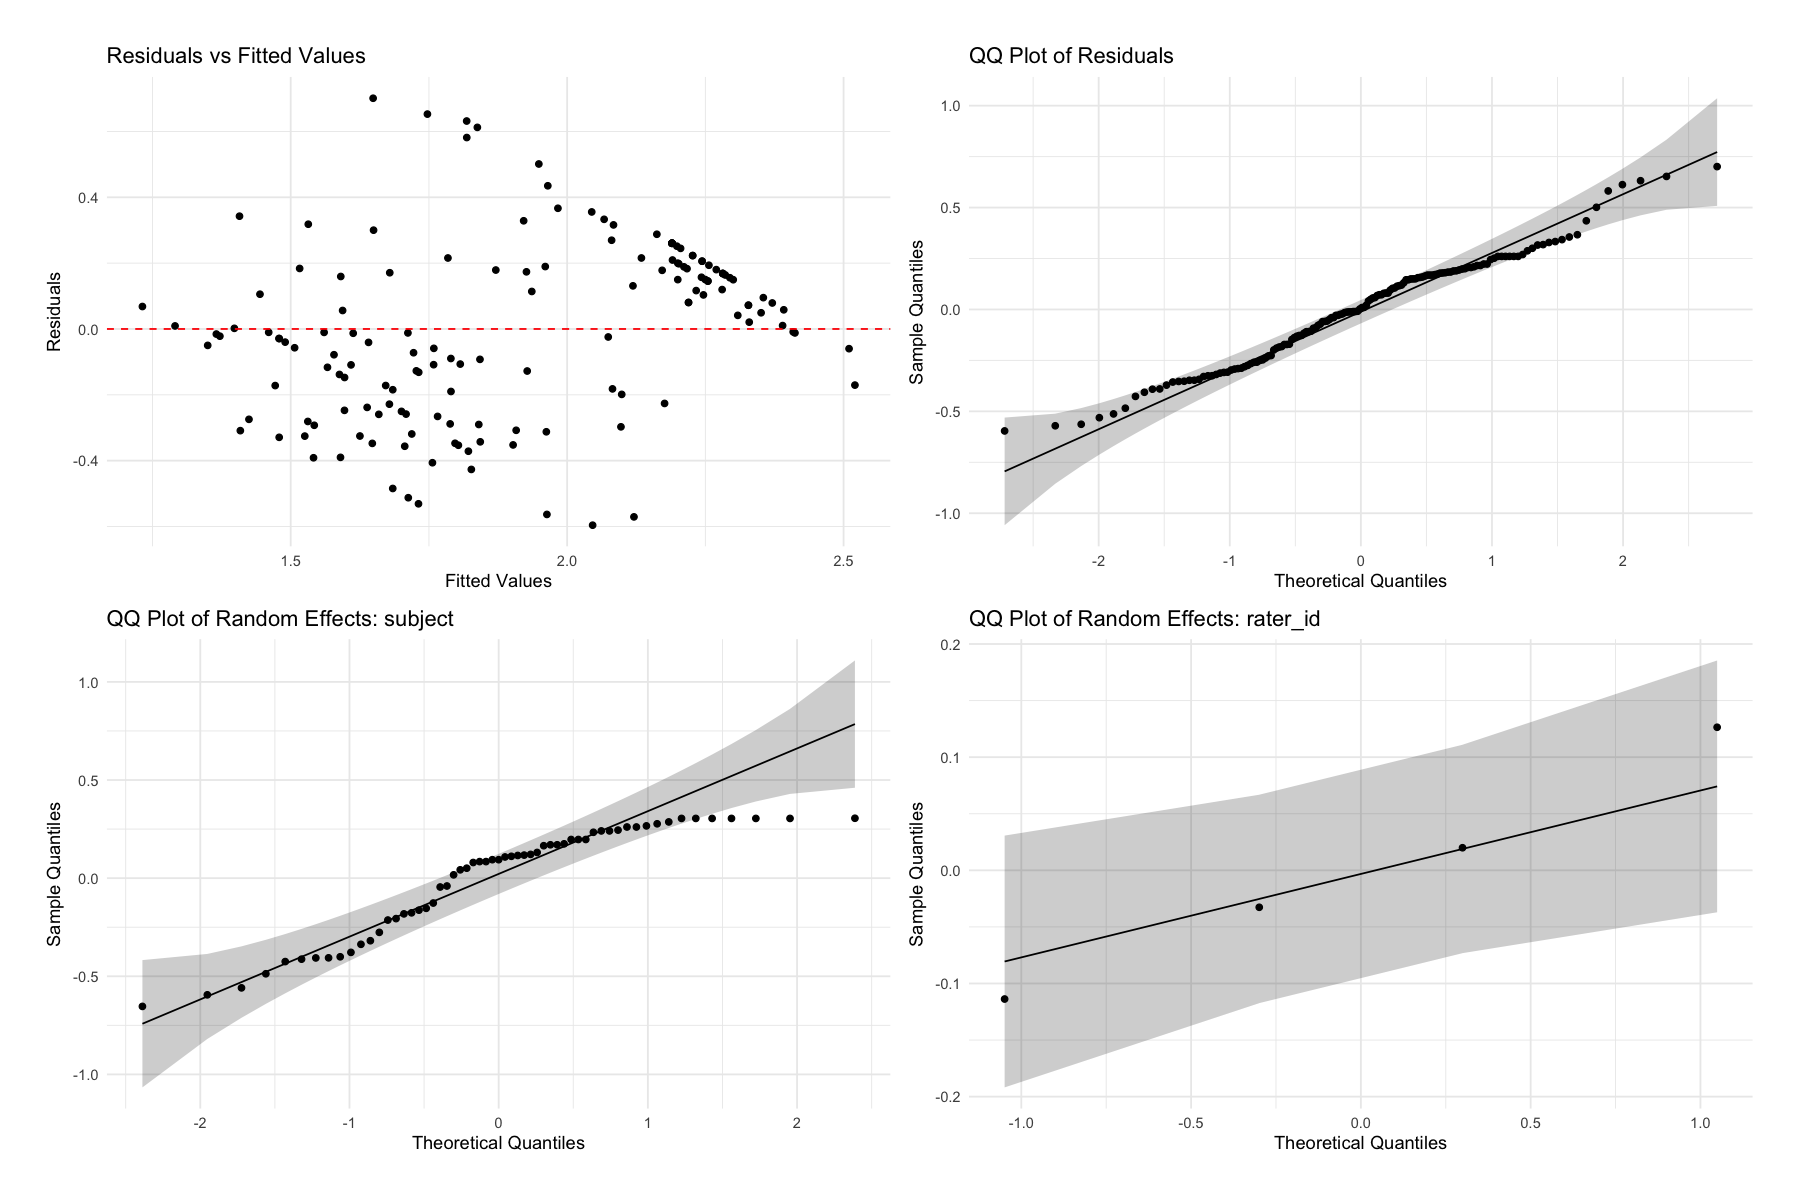

In [119]:
## Fit model with defaced as random effect
library(lme4)
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id), data=df_poor)
summary(fm1)
suppressWarnings(p1_poor <- visualize_lmer_fit(fm1, figure_title = "Alternative model with only poor quality and excluded scans"))

In [120]:
#Likelihood-ratio test
anova(fm0, fm1)

#Extract p-value
pval_poor <- anova(fm0, fm1)$'Pr(>Chisq)'[2]

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,166.5509,178.6464,-79.27544,158.5509,NA,NA,NA
fm1,5,164.1495,179.2689,-77.07475,154.1495,4.401385,1,0.03590976


refitting model(s) with ML (instead of REML)



# Results summary

TableGrob (3 x 2) "arrange": 6 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]
2 2 (1-1,2-2) arrange gtable[arrange]
3 3 (2-2,1-1) arrange gtable[arrange]
4 4 (2-2,2-2) arrange gtable[arrange]
5 5 (3-3,1-1) arrange gtable[arrange]
6 6 (3-3,2-2) arrange gtable[arrange]


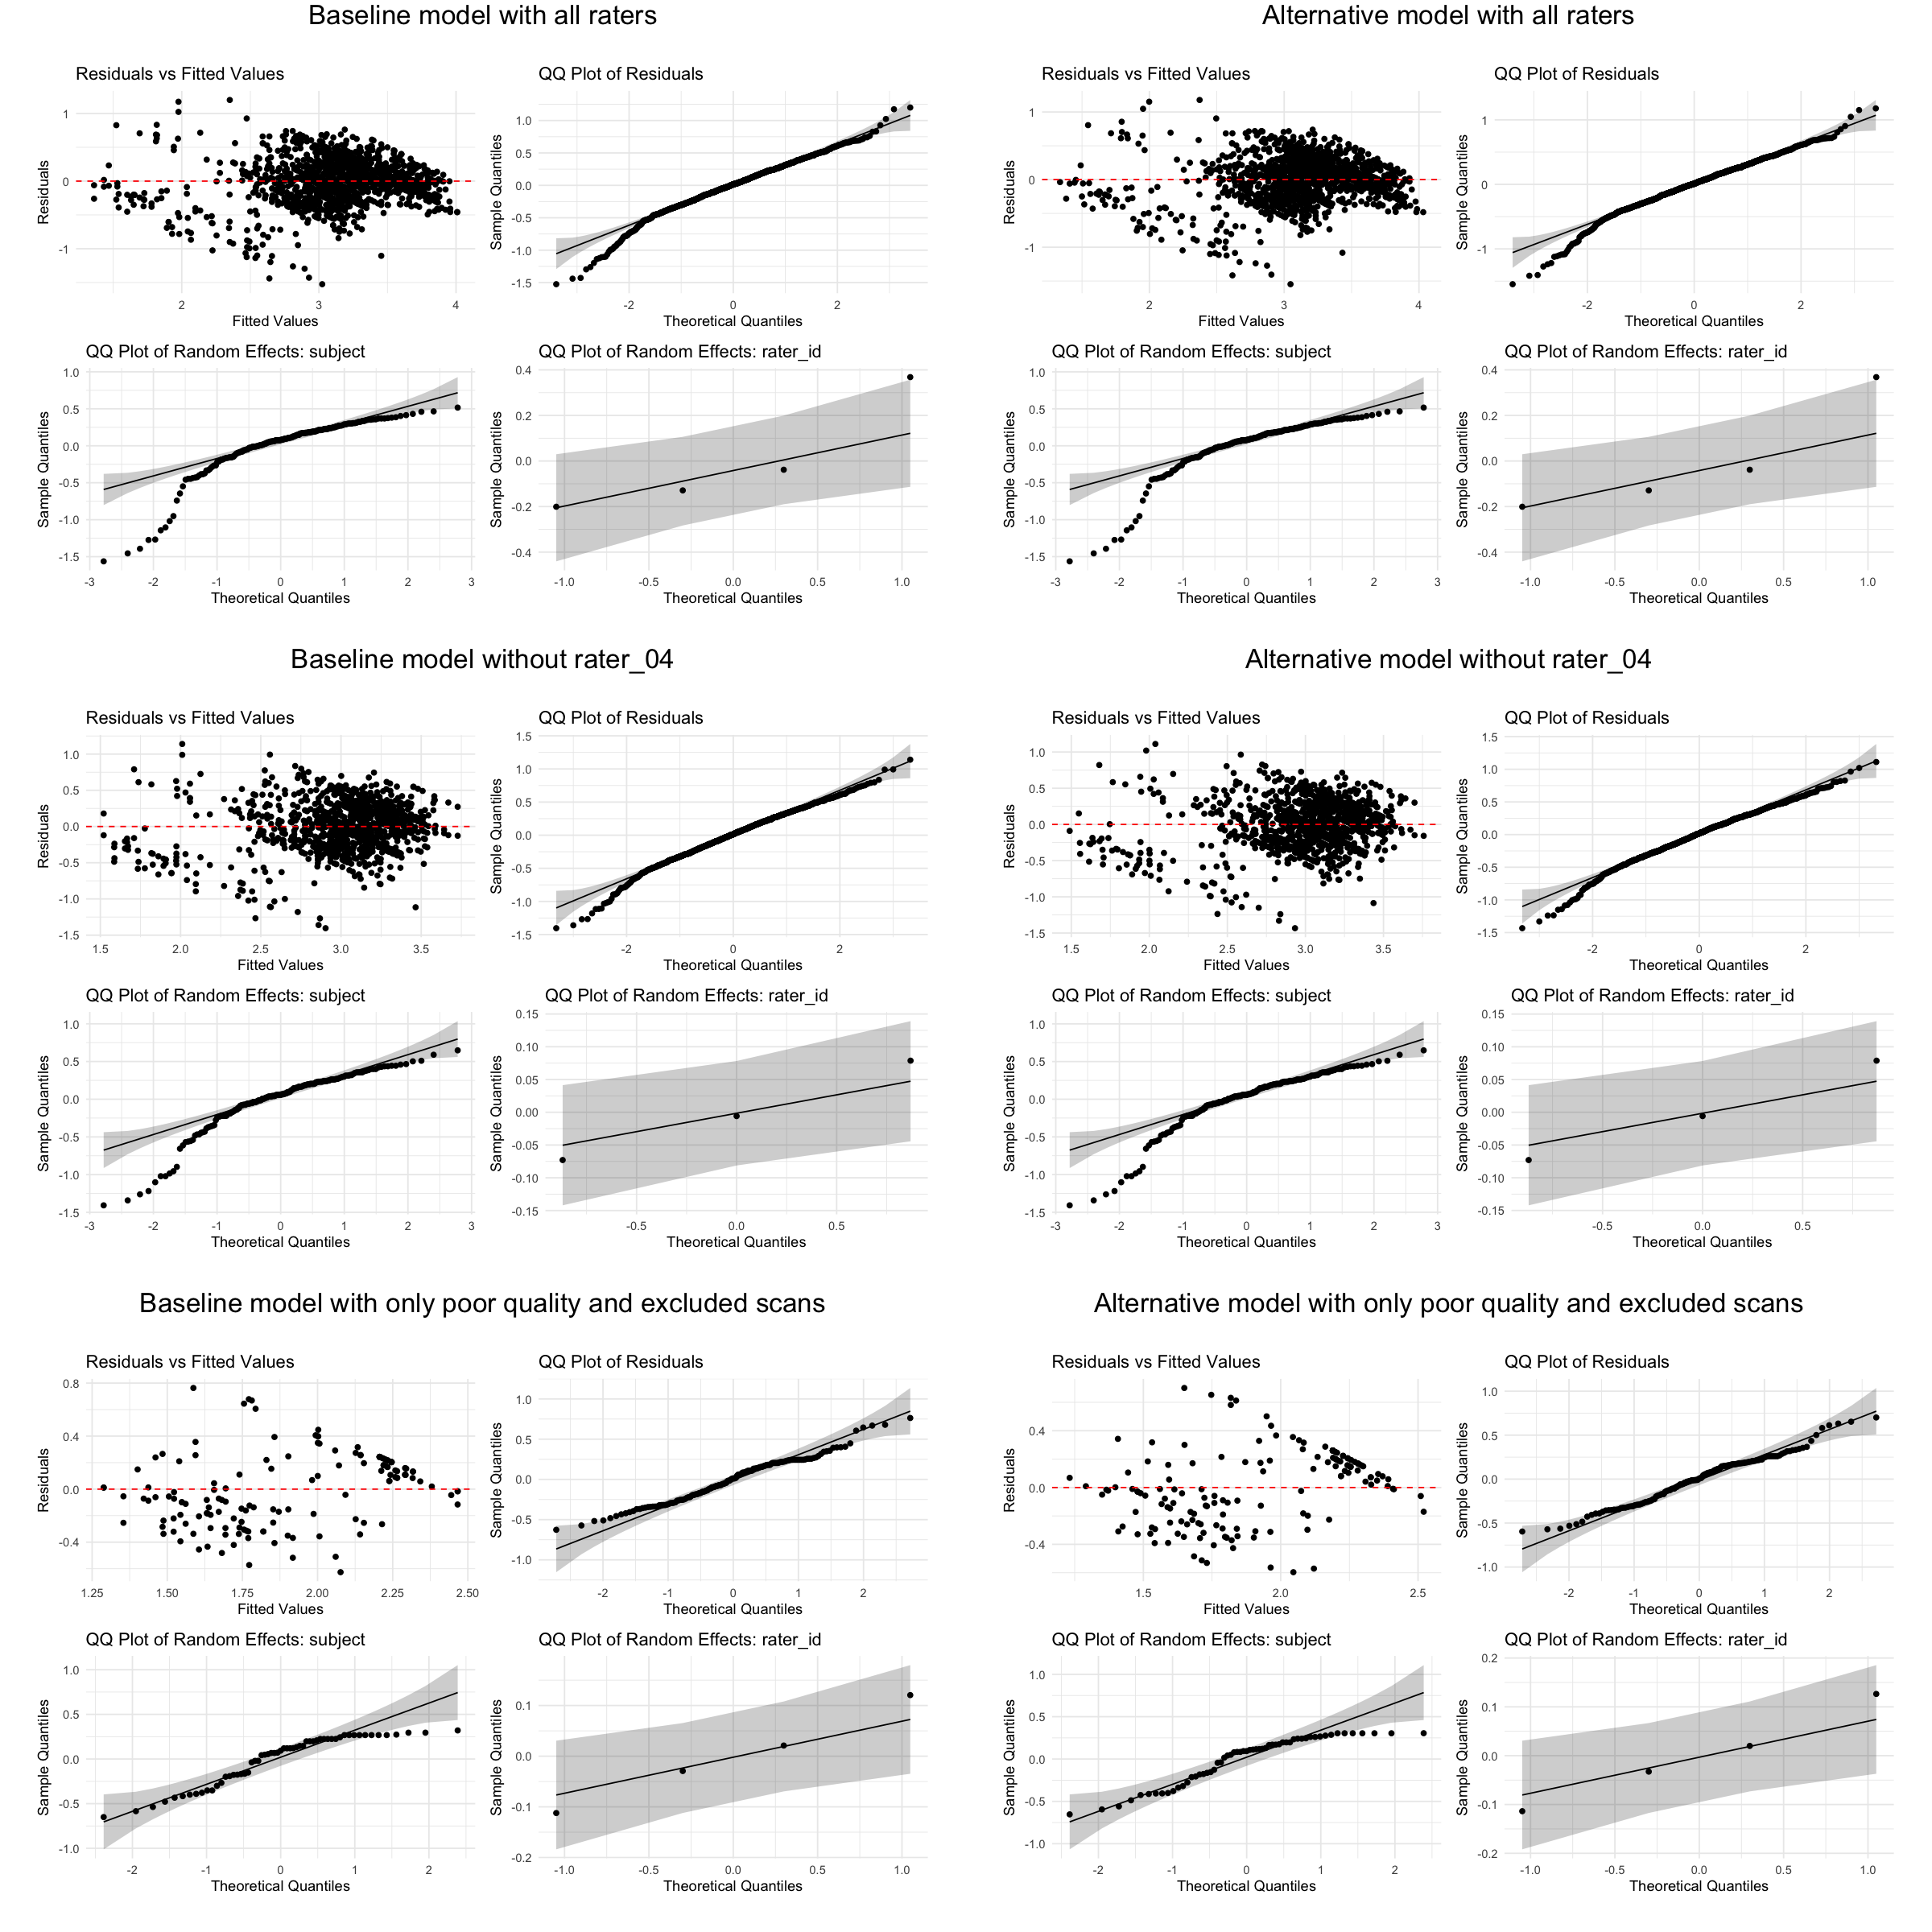

In [121]:
# Combine all diagnostic plots (p0 and p1) into a single figure
library(gridExtra)
library(grid)
options(repr.plot.width=20, repr.plot.height=20)

all_combined_plot <- grid.arrange(p0, p1, p0_w04, p1_w04, p0_poor, p1_poor, ncol = 2)
print(all_combined_plot)


# Sanity check with simulated data

We verify that the model selected is able to detect differences when a bias has been manually introduced in simulated data and vice versa that the model does not detect differences when no bias was introduced. The simulated data were generated by running `../../data/simulate_data.R`

In [122]:
library(lme4)
# Load simulated data
simulated_df <- readRDS(("../../data/simulated_normal_ratings.rds"))

#Fit the models
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=simulated_df)
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id), data=simulated_df)

#Likelihood-ratio test
anova(fm0, fm1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,11136.61,11157.81,-5564.305,11128.61,NA,NA,NA
fm1,5,11070.52,11097.02,-5530.262,11060.52,68.08651,1,1.564776e-16


All good, we see that the simulated bias is detected by our linear mixed-effects model.

In [123]:
library(lme4)
# Load the simulated data without bias
simulated_df_no_bias <- readRDS(("../../data/simulated_normal_nobias_ratings.rds"))

#Fit the models
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=simulated_df_no_bias)
fm1 <- lmer(as.numeric(rating) ~ defaced + (1 | subject) + (1 | rater_id), data=simulated_df_no_bias)

#Likelihood-ratio test
anova(fm0, fm1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,10937.58,10958.78,-5464.792,10929.58,NA,NA,NA
fm1,5,10939.54,10966.04,-5464.771,10929.54,0.04041613,1,0.8406691


We also verified that no bias is found by our models when it is not introduced in the simulated data.